In [ ]:
#| default_exp normalization

## Within-condition normalization
It is common practice and highly recommended to measure multiple samples of a given condition. This ensures that observed changes between conditions are not just due to random variation. Examples of samples within the same condition could be biological replicates, but also patients with the same clinical condition. 
We want to ensure that systematic changes between within-condition samples are corrected for as follows:

* Our assumed input values are log2 transformed peptide ion intensities, which are stored in a 2d numpy array called "samples". Each row in samples represents a peptide and each column represents a sample

* In a first step, we determine the all pairwise distances between the samples (details explained below)
* We then choose the pair of samples with the closest distance between each other
* We randomly choose one "anchor" sample and one "shift" sample and we subtract the distance between the samples from each peptide intensity measured in the "shift" sample. This is equivalent to rescaling the intensities of the original sample by a constant factor such that the distributions are aligned
* We then construct a virtual "merged" sample by computing the average intensities of anchor and shift sample
* We repeat the steps above until all samples are merged. Keeping track of the shift factors allows us then to determine an ideal shift for each sample



### Find the best matching pair
Take all pairs of the columns in the "samples" array that have not been already merged and compute the distance between the pairs as follows:
* Subtract sample1 from sample2 (or sample2 from sample1, the order does not matter)
* This results in a distribution of differences. As the samples array contains log2 intensities, this corresponds to taking log2 fold changes
* Take the median of the distribution, this is a good approximation for the change between the two distributions
* Select the two samples with the lowest absolute change

### Shifting samples
When we have computed the distance between two samples, we want to correct one of the samples by this distance. This results in two distributions with the same median value. We always shift the sample which has been merged from fewer distributions (see below for details). The sample to which the shift is applied is call "shift" sample and the sample which is not shifted is called "anchor" sample.
A "total shift" is calculated after all samples are merged, just by following up how many shifts have been applied to a sample in total

### Merging distributions
After we shift two distributions on top of each other, we calculate a "merged" distribution. Each intensity in the merged distribution is the average of the intensity in both distributions. For the merging we have to take into account the following: If for example the anchor sample has already been merged from 10 samples, and the shift distribution has not been merged at all, we want to weigh the distribution coming from many samples higher. We hence multiply each sample by the number of merges.

## Wrapper functions

## Shift linear to reference

## Unit tests

In [ ]:
#| include: false
import numpy as np
import directlfq.normalization as lfq_norm

def test_merged_distribs():
    anchor_distrib = np.array([1, 1, 1, 1, 1])
    shift_distrib = np.array([2, 2, 2, 2, 2])
    counts_anchor_distrib = 4
    counts_shifted_distib = 1
    assert (lfq_norm.merge_distribs(anchor_distrib, shift_distrib, counts_anchor_distrib, counts_shifted_distib)== np.array([1.2, 1.2, 1.2, 1.2, 1.2])).any()


test_merged_distribs() 


In [ ]:
#| include: false
import numpy as np
import pandas as pd
import directlfq.normalization as lfq_norm


def test_order_of_shifts():
    vals1 = [1, np.nan, 1.5]
    vals2 = [1, 1, np.nan]
    vals3 = [3.2, 1, 2.8]
    vals4 = [4.2, 2, 3.8]
    list_of_vals = [vals1, vals2, vals3, vals4]
    protein_profile_df = create_input_df_from_input_vals(list_of_vals)
    display(protein_profile_df)
    protein_profile_numpy = protein_profile_df.to_numpy()
    sample2shift = lfq_norm.get_normfacts(protein_profile_numpy)
    assert sample2shift == {1: 0.0, 2: -1.2999999999999998, 3: -2.3}
    print(lfq_norm.create_distance_matrix(protein_profile_numpy, metric = 'variance'))
    
    df_normed = pd.DataFrame(lfq_norm.apply_sampleshifts(protein_profile_numpy, sample2shift), index = protein_profile_df.index, columns = protein_profile_df.columns)
    display(df_normed)

def create_input_df_from_input_vals(list_of_vals):
    index_vals = [("A", f"ion{x}") for x in range(len(list_of_vals))]
    index = pd.Index(index_vals, name=('protein', 'ion'))
    return pd.DataFrame(list_of_vals, index=index)


In [ ]:

test_order_of_shifts()

0    1    2
protein ion                
A       ion0  1.0  NaN  1.5
        ion1  1.0  1.0  NaN
        ion2  3.2  1.0  2.8
        ion3  4.2  2.0  3.8

[[   inf 0.     0.2025 0.2025]
 [   inf    inf 1.21   1.21  ]
 [   inf    inf    inf 0.    ]
 [   inf    inf    inf    inf]]


0    1    2
protein ion                
A       ion0  1.0  NaN  1.5
        ion1  1.0  1.0  NaN
        ion2  1.9 -0.3  1.5
        ion3  1.9 -0.3  1.5

STDev 1.00552274962018


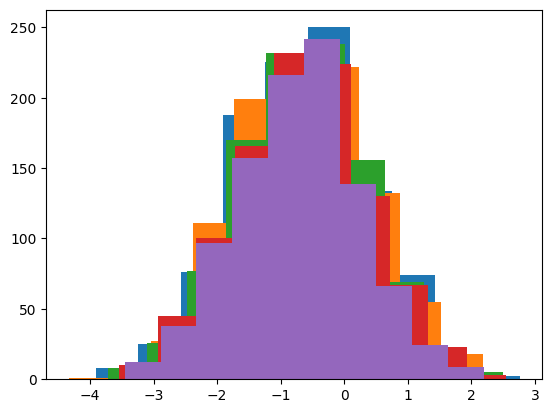

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import directlfq.normalization as lfq_norm

def generate_randarrays(number_arrays,size_of_array):
    randarray = []
    for i in range(number_arrays):
        shift = np.random.uniform(low=-10, high=+10)
        randarray.append(np.random.normal(loc=shift, size=size_of_array))
    return np.array(randarray)

def test_sampleshift(samples):
    num_samples = samples.shape[0]
    merged_sample = []
    for i in range(num_samples):
        plt.hist(samples[i])
        merged_sample.extend(samples[i])
    stdev = np.std(merged_sample)
    print(f"STDev {stdev}")
    assert (stdev <=1.2) 
    
    plt.show()
randarray = generate_randarrays(5, 1000)
sample2shift = lfq_norm.get_normfacts(randarray)
normalized_randarray = lfq_norm.apply_sampleshifts(randarray, sample2shift)
test_sampleshift(normalized_randarray)

In [ ]:
#| include: false
import directlfq.visualizations as lfq_viz
import directlfq.utils as lfq_utils
import directlfq.normalization as lfq_norm

def test_normalizing_between_samples(num_samples_quadratic):
    input_file = "../test_data/unit_tests/protein_normalization/peptides.txt.maxquant_peptides_benchmarking.aq_reformat.tsv"
    input_df = pd.read_csv(input_file, sep = '\t')
    input_df = lfq_utils.index_and_log_transform_input_df(input_df)
    input_df = input_df[[x for x in input_df.columns if "Shotgun" in x]]
    lfq_viz.plot_withincond_fcs(input_df)
    input_df_normalized = lfq_norm.NormalizationManagerSamples(input_df, num_samples_quadratic=num_samples_quadratic).complete_dataframe
    lfq_viz.plot_withincond_fcs(input_df_normalized)
    assert_that_results_scatter_around_zero(input_df_normalized)


def assert_that_results_scatter_around_zero(input_df_normalized):
    median_intensities = input_df_normalized.median(axis=1)
    input_df_subtracted = input_df_normalized.subtract(median_intensities, axis=0)
    median_of_medians = input_df_subtracted.median(axis=0)
    assert (median_of_medians < 0.1).all()
    print("checked that close to zero")


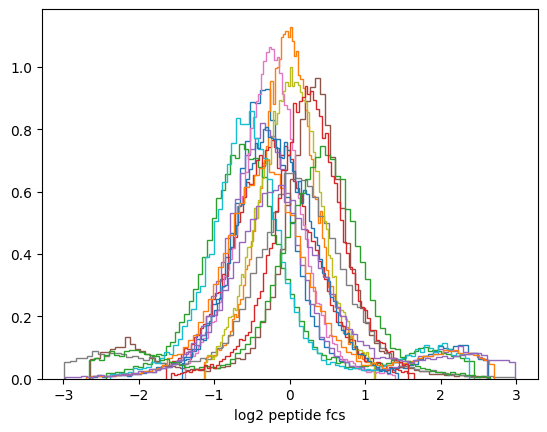

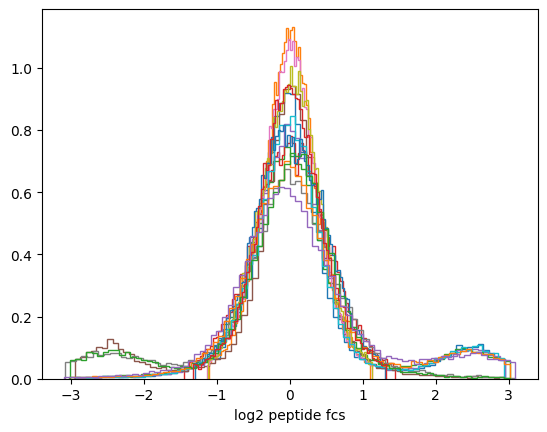

checked that close to zero


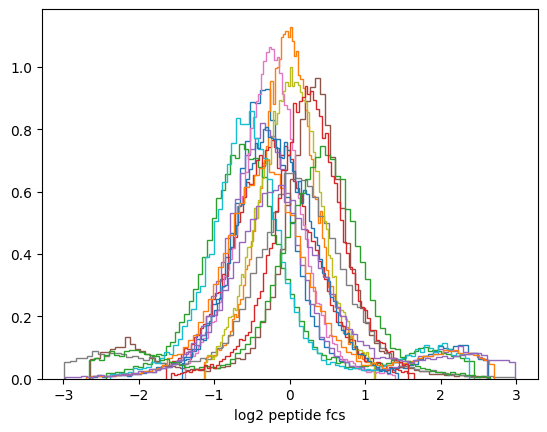

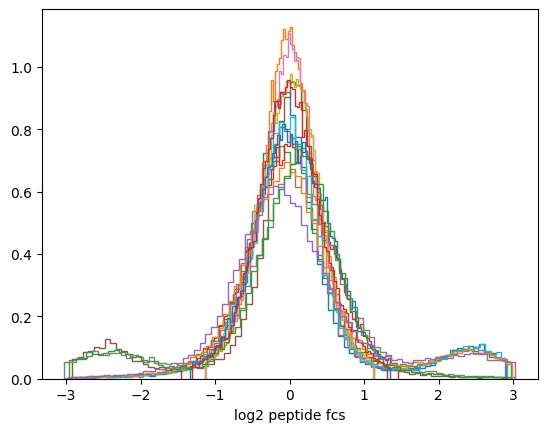

checked that close to zero


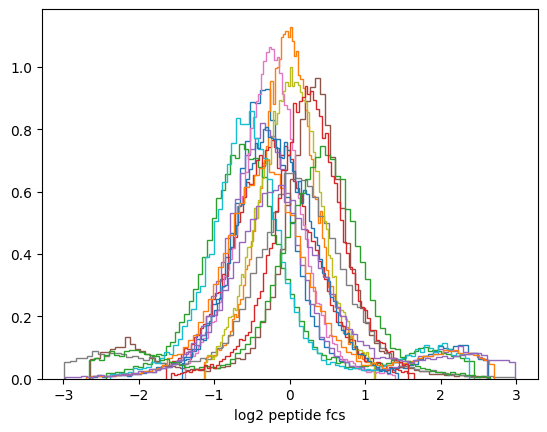

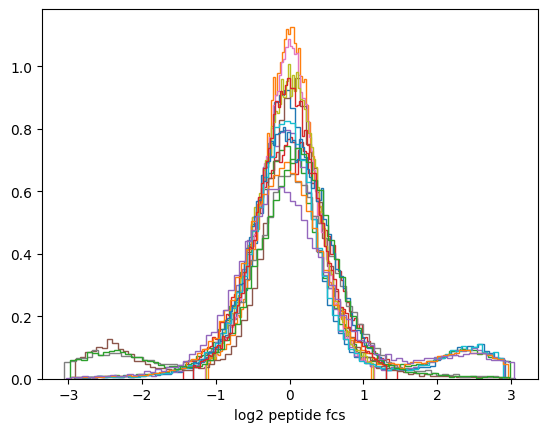

checked that close to zero


In [ ]:

test_normalizing_between_samples(100)
test_normalizing_between_samples(3)
test_normalizing_between_samples(1)

In [ ]:
import directlfq.normalization as lfq_norm
import directlfq.test_utils as lfq_test_utils
import numpy as np

def test_that_profiles_without_noise_are_shifted_exactly_on_top_of_each_other():
    peptide1= lfq_test_utils.PeptideProfile(protein_name="protA", fraction_zeros_in_profile=0.1, systematic_peptide_shift=3000, add_noise=False)
    peptide2= lfq_test_utils.PeptideProfile(protein_name="protA",fraction_zeros_in_profile=0.9, systematic_peptide_shift=3, add_noise=False)
    peptide3= lfq_test_utils.PeptideProfile(protein_name="protA", fraction_zeros_in_profile=0.1, systematic_peptide_shift=0.1, add_noise=False)
    peptide4= lfq_test_utils.PeptideProfile(protein_name="protA",fraction_zeros_in_profile=0.9, systematic_peptide_shift=100, add_noise=False)
    protein_df = lfq_test_utils.ProteinProfileGenerator([peptide1, peptide2, peptide3, peptide4]).protein_profile_dataframe
    display(protein_df)
    normed_ion_profile = lfq_norm.normalize_ion_profiles(protein_df)
    display(normed_ion_profile)
    column_from_shifted = normed_ion_profile.iloc[:,11].dropna().to_numpy()
    display(column_from_shifted)
    assert np.allclose(column_from_shifted, column_from_shifted[0])

def test_that_profiles_with_noise_are_close():
    peptide1= lfq_test_utils.PeptideProfile(protein_name="protA", fraction_zeros_in_profile=0, systematic_peptide_shift=3000, add_noise=True)
    peptide2= lfq_test_utils.PeptideProfile(protein_name="protA",fraction_zeros_in_profile=0, systematic_peptide_shift=3, add_noise=True)
    peptide3= lfq_test_utils.PeptideProfile(protein_name="protA", fraction_zeros_in_profile=0, systematic_peptide_shift=0.1, add_noise=True)
    peptide4= lfq_test_utils.PeptideProfile(protein_name="protA",fraction_zeros_in_profile=0, systematic_peptide_shift=100, add_noise=True)

    protein_df = lfq_test_utils.ProteinProfileGenerator([peptide1, peptide2, peptide3, peptide4]).protein_profile_dataframe
    display(protein_df)
    
    normed_ion_profile = lfq_norm.normalize_ion_profiles(protein_df)
    display(normed_ion_profile)
    column_from_shifted = normed_ion_profile.iloc[:,9].dropna().to_numpy()

    assert np.allclose(column_from_shifted, column_from_shifted[0],rtol=0.01, atol=0.01)

test_that_profiles_without_noise_are_shifted_exactly_on_top_of_each_other()
test_that_profiles_with_noise_are_close()


0          1          2          3          4          5   \
protein ion                                                                     
protA   0    44.602965  44.474241  41.489085  43.216307  43.505708  42.338404   
        1          NaN        NaN        NaN        NaN        NaN  32.372620   
        2    29.730290        NaN  26.616410  28.343632  28.633033  27.465729   
        3          NaN        NaN        NaN  38.309416        NaN        NaN   

                    6          7          8          9          10         11  \
protein ion                                                                     
protA   0    43.454211  43.102621        NaN  43.625508  43.261340  40.203349   
        1          NaN        NaN        NaN        NaN  33.295555        NaN   
        2    28.581537  28.229946  27.024859        NaN  28.388665  25.330674   
        3          NaN        NaN        NaN        NaN        NaN        NaN   

                    12         13         14         15         16         17  \
protein ion                                                                     
protA   0    44.447364  44.554027        NaN  44.701690  43.106703  44.630975   
        1          NaN        NaN        NaN        NaN        NaN        NaN   
        2    29.574689  29.681352  29.819668  29.829015  28.234029  29.758301   
        3          NaN        NaN        NaN        NaN        NaN        NaN   

                    18         19  
protein ion                        
protA   0    43.380650  43.407413  
        1          NaN        NaN  
        2    28.507975  28.534739  
        3          NaN  38.500523

0          1          2          3          4          5   \
protein ion                                                                     
protA   0    44.602965  44.474241  41.489085  43.216307  43.505708  42.338404   
        1          NaN        NaN        NaN        NaN        NaN  42.338404   
        2    44.602965        NaN  41.489085  43.216307  43.505708  42.338404   
        3          NaN        NaN        NaN  43.216307        NaN        NaN   

                    6          7          8          9         10         11  \
protein ion                                                                    
protA   0    43.454211  43.102621        NaN  43.625508  43.26134  40.203349   
        1          NaN        NaN        NaN        NaN  43.26134        NaN   
        2    43.454211  43.102621  41.897534        NaN  43.26134  40.203349   
        3          NaN        NaN        NaN        NaN       NaN        NaN   

                    12         13         14        15         16         17  \
protein ion                                                                    
protA   0    44.447364  44.554027        NaN  44.70169  43.106703  44.630975   
        1          NaN        NaN        NaN       NaN        NaN        NaN   
        2    44.447364  44.554027  44.692343  44.70169  43.106703  44.630975   
        3          NaN        NaN        NaN       NaN        NaN        NaN   

                   18         19  
protein ion                       
protA   0    43.38065  43.407413  
        1         NaN        NaN  
        2    43.38065  43.407413  
        3         NaN  43.407413

array([40.20334853, 40.20334853])

0          1          2          3          4          5   \
protein ion                                                                     
protA   0    44.602965  44.474240  41.489086  43.216307  43.505707  42.338403   
        1    34.637183  34.508466  31.523304  33.250513  33.539938  32.372596   
        2    29.730277  29.601571  26.616437  28.343610  28.633046  27.465862   
        3    39.696073  39.567351  36.582195  38.309418  38.598818  37.431514   

                    6          7          8          9          10         11  \
protein ion                                                                     
protA   0    43.454211  43.102621  41.897534  43.625507  43.261340  40.203350   
        1    33.488411  33.136842  31.931754  33.659705  33.295576  30.237528   
        2    28.581511  28.229973  27.024729  28.752908  28.388656  25.330359   
        3    38.547322  38.195730  36.990645  38.718618  38.354451  35.296454   

                    12         13         14         15         16         17  \
protein ion                                                                     
protA   0    44.447363  44.554027  44.692343  44.701690  43.106704  44.630975   
        1    34.481577  34.588235  34.726546  34.735907  33.140926  34.665195   
        2    29.574714  29.681435  29.819588  29.829101  28.234120  29.758310   
        3    39.540471  39.647134  39.785452  39.794799  38.199811  39.724087   

                    18         19  
protein ion                        
protA   0    43.380650  43.407413  
        1    33.414866  33.441616  
        2    28.507973  28.534678  
        3    38.473753  38.500520

0          1          2          3          4          5   \
protein ion                                                                     
protA   0    44.602965  44.474240  41.489086  43.216307  43.505707  42.338403   
        1    44.602966  44.474248  41.489086  43.216295  43.505721  42.338378   
        2    44.602946  44.474240  41.489106  43.216279  43.505716  42.338531   
        3    44.602963  44.474242  41.489086  43.216308  43.505708  42.338404   

                    6          7          8          9          10         11  \
protein ion                                                                     
protA   0    43.454211  43.102621  41.897534  43.625507  43.261340  40.203350   
        1    43.454193  43.102625  41.897536  43.625487  43.261359  40.203311   
        2    43.454181  43.102643  41.897398  43.625578  43.261325  40.203028   
        3    43.454212  43.102620  41.897536  43.625509  43.261341  40.203344   

                    12         13         14         15         16         17  \
protein ion                                                                     
protA   0    44.447363  44.554027  44.692343  44.701690  43.106704  44.630975   
        1    44.447360  44.554017  44.692328  44.701689  43.106708  44.630978   
        2    44.447383  44.554104  44.692257  44.701770  43.106790  44.630980   
        3    44.447361  44.554024  44.692342  44.701690  43.106701  44.630977   

                    18         19  
protein ion                        
protA   0    43.380650  43.407413  
        1    43.380649  43.407399  
        2    43.380643  43.407348  
        3    43.380643  43.407411

In [7]:
import directlfq.normalization as lfq_norm
import numpy as np

def _calc_distance(samples_1, samples_2):
    distrib = lfq_norm.get_fcdistrib(samples_1, samples_2)
    is_all_nan = np.all(np.isnan(distrib))
    if is_all_nan:
        return np.nan
    else:
        return np.nanmedian(distrib)

def test_calc_distance():
    print("Test 2: One array is entirely NaN")
    samples_1 = np.array([np.nan, np.nan, np.nan])
    samples_2 = np.array([1, 2, 3])
    assert np.isnan(lfq_norm.SampleShifterLinear._calc_distance(samples_1, samples_2)) == True, "Test 2 failed: Expected NaN for an array entirely of NaNs"
    

    print("Test 1: Both arrays are non-NaN and identical")
    samples_1 = np.array([1, 2, 3])
    samples_2 = np.array([1, 2, 3])
    assert np.isnan(_calc_distance(samples_1, samples_2)) == False, "Test 1 failed: Expected a non-NaN result for identical arrays"
    assert lfq_norm.SampleShifterLinear._calc_distance(samples_1, samples_2) == 0, "Test 1 failed: Expected a distance of 0 for identical arrays"
    

    print("Test 3: Arrays with some NaN values")
    samples_1 = np.array([1, np.nan, 3])
    samples_2 = np.array([13, 2, np.nan])
    assert np.isnan(_calc_distance(samples_1, samples_2)) == False, "Test 3 failed: Expected a valid number even with some NaNs"
    assert lfq_norm.SampleShifterLinear._calc_distance(samples_1, samples_2) == -12 , "Test 3 failed: Expected a distance of -12"
    
    print("Test 4: Arrays with different values but no NaNs")
    samples_1 = np.array([1, 4, 7])
    samples_2 = np.array([2, 5, 8])
    assert lfq_norm.SampleShifterLinear._calc_distance(samples_1, samples_2) != 0, "Test 4 failed: Expected a non-zero distance for different values"
    
    print("Test 5: Empty arrays")
    samples_1 = np.array([])
    samples_2 = np.array([])
    assert np.isnan(lfq_norm.SampleShifterLinear._calc_distance(samples_1, samples_2)) == True, "Test 5 failed: Expected NaN for empty arrays"

    print("All tests passed!")

# Run the test function
test_calc_distance()

Test 2: One array is entirely NaN
Test 1: Both arrays are non-NaN and identical
Test 3: Arrays with some NaN values
Test 4: Arrays with different values but no NaNs
Test 5: Empty arrays
All tests passed!


## Learning Tests

In [ ]:
import numpy as np
import seaborn as sns

def test_taking_the_mean_along_an_axis():

    example_set = sns.load_dataset("iris").set_index("species")

    example_mean = example_set.mean(axis=1)

    assert example_mean.to_numpy()[3] == np.mean([4.6, 3.1, 1.5, 0.2])


In [ ]:

test_taking_the_mean_along_an_axis()